In [91]:
from typing import Union, Optional
from pathlib import Path
import json
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from loguru import logger
import pandas as pd

# from piglegsurgeryweb.uploader.views import show_collection_reports_list

HEATMAP_EXPERT_POINTS_PATH = list(Path("./").glob("*points_normalized.*.npy"))[-1]


assert HEATMAP_EXPERT_POINTS_PATH.exists()



/webapps/piglegsurgery/devel
 2024-02_pigleg_stats_evalutaion_students_stats.ipynb
 2024-05_pigleg_eval_stresstest.ipynb
 2024-06_pigleg_eval_dataset2024-06_all_stitches.ipynb
 2024-06_pigleg_eval_dataset2024-06_all_stitches_with_skin_model.ipynb
 2024-06_pigleg_eval_pretest_posttest_all_stitches.ipynb
 2024-06_pigleg_eval_pretest_posttest_first_stitch.ipynb
 2024-06_pigleg_eval_pretest_posttest_first_stitch_paired.ipynb
'2024-07 experiment_evaluation.xlsx'
 2024-07_list_of_all_stitches_sorted_by_duration.2024-07-19_17-44-06.xlsx
 2024-07_list_of_all_stitches_sorted_by_duration.2024-07-19_17-44-31.xlsx
 2024-07_list_of_all_stitches_sorted_by_duration.2024-07-30_14-33-32.xlsx
 2024-07_list_of_all_stitches_sorted_by_duration.2024-08-01_15-02-12.xlsx
 2024-07_list_of_all_stitches_sorted_by_duration.2024-08-28_10-29-59.xlsx
 2024-07_list_of_all_stitches_sorted_by_duration.2024-08-29_09-54-42.xlsx
 2024-07_list_of_all_stitches_sorted_by_duration.2024-09-02_16-28-55.xlsx
 2024-07_list_of_all

In [93]:

fn = sorted(list(Path(".").glob("*list_of_all_stitches*.xlsx")))[-1]
print(fn)
dfall = pd.read_excel(fn)

if "done_by_expert" not in dfall.columns:
    dfall["done_by_expert"] = dfall["filename"].str.contains("Ekn").astype(float)
    dfall["done_by_expert"] = dfall["done_by_expert"].astype(bool)
# dfall.done_by_expert.value_counts()


list_of_all_stitches_sorted_by_duration.2025-02-14_21-57-22.xlsx


In [79]:

MEDIA_ROOT = Path("../piglegsurgeryweb/media/")

def get_outputdir(patch:str):
    img_pths = list((MEDIA_ROOT / "upload/").glob(f"*/*{patch}*"))
    mediafile_path = img_pths[-1]
    mediafile_path = mediafile_path.absolute().resolve()

    outputdir = list(list((MEDIA_ROOT ).glob(f"*/*{patch}*.zip"))[-1].parent.glob("*/meta.json"))[-1].parent

    outputdir = outputdir.absolute().resolve()
    return outputdir, mediafile_path



In [105]:
fn = dfall[dfall["done_by_expert"]==False].filename.values[8]
patch = Path(fn).stem
patch
outputdir, mediafile_path = get_outputdir(patch)
outputdir
mediafile_path


PosixPath('/webapps/piglegsurgery/piglegsurgeryweb/media/upload/20241008-121856_IMG_4981_3f179a0caf4f7c6238acd5327d39d6454585f547/IMG_4981.preview.jpg')

PosixPath('/webapps/piglegsurgery/piglegsurgeryweb/media/upload/20220620-102621_Bad-12_10_21__Loewe__Rebekka__Einzelknopfnaht_75554cec0240e7dff8ec55619af99d2302fb8a74/Bad-12_10_21__Loewe__Rebekka__Einzelknopfnaht.mp4')

In [193]:
def compare_distributions_by_l2_distance(pts, points, bw_adjust1=1.0, bw_adjust2=1.0):
    # Compute both KDEs.
    kde_ground = gaussian_kde(pts.T)
    kde_other = gaussian_kde(points.T)

    kde_ground.set_bandwidth(bw_method=kde_ground.factor * bw_adjust1)
    kde_other.set_bandwidth(bw_method=kde_other.factor * bw_adjust2)

    # Define a common grid that covers the support of both datasets.
    x_min = min(pts[:, 0].min(), points[:, 0].min())
    x_max = max(pts[:, 0].max(), points[:, 0].max())
    y_min = min(pts[:, 1].min(), points[:, 1].min())
    y_max = max(pts[:, 1].max(), points[:, 1].max())

    grid_size = 20
    x_grid = np.linspace(x_min, x_max, grid_size)
    y_grid = np.linspace(y_min, y_max, grid_size)
    X, Y = np.meshgrid(x_grid, y_grid)
    grid_coords = np.vstack([X.ravel(), Y.ravel()])

    # Evaluate both KDEs on the grid.
    density_ground = kde_ground(grid_coords).reshape(X.shape)
    density_other  = kde_other(grid_coords).reshape(X.shape)

    # Calculate a similarity measure (for example, L2 distance).
    l2_distance = np.sqrt(np.sum((density_ground - density_other)**2))
    # print("L2 distance between KDEs:", l2_distance)
    return l2_distance


def logistic_normalize(d, midpoint=700, steepness=0.01):
    """
    Uses a logistic function to normalize the distance.

    Parameters:
      d (float or np.ndarray): The distance value(s).
      midpoint (float): The distance value corresponding to 0.5.
      steepness (float): Controls the slope of the logistic curve.

    Returns:
      float or np.ndarray: A normalized value between 0 and 1.
    """
    return 1 / (1 + np.exp(-steepness * (d - midpoint)))

def logistic_normalize_inverted(d, midpoint=700, steepness=0.01):
    """
    Normalizes a distance d so that:
      - d = 0 maps to 1.0 (best),
      - d = midpoint maps to 0.5,
      - d -> infinity maps to 0.0.

    Parameters:
      d (float or np.ndarray): The distance value(s).
      midpoint (float): The distance at which the result is 0.5.
      steepness (float): Controls the slope of the logistic curve.

    Returns:
      float or np.ndarray: A normalized value in the range [0, 1].
    """
    # Ensure d is a NumPy array for vectorized operations
    d = np.array(d, dtype=float)
    normalized = 1 / (1 + np.exp(steepness * (d - midpoint)))

    # If you want to force exactly 1.0 when d == 0, adjust those entries:
    # normalized[d == 0] = 1.0

    return normalized


def compare_heatmaps_plot(
        outputdir: Union[str,Path], points_px:Optional[np.array]=None, pix_size_m:Optional[float]=None, filename=None,
        image:Optional[np.array]=None,
        tool_id=0,
        cmap="Greens",
        levels=3
):

    outputdir = Path(outputdir)
    if pix_size_m is None:
        with open(outputdir / "meta.json", "r") as f:
            meta = json.load(f)
        pix_size_m = meta["qr_data"]["pix_size"]

    if points_px is None:
        with open(outputdir / "tracks_points.json", "r") as f:
            tracks_points = json.load(f)
        points_px = np.asarray(tracks_points["data_pixels"][tool_id])
    else:
        points_px = np.asarray(points_px)

    logger.debug(f"{points_px.shape=}")
    logger.debug(f"{pix_size_m=}")
    if points_px.size < 8:
        logger.warning("No points found for heatmap")
        return None, None
    if pix_size_m is None:
        logger.warning("No pix_size_m found for heatmap")
        return None, None
    # points_m = points_px * pix_size_m

    pts_gt = np.load(HEATMAP_EXPERT_POINTS_PATH)

    plt.figure()

    if image is None:
        fn_small = list(outputdir.glob("__cropped.*.jpg"))[0]
        image = skimage.io.imread(fn_small, as_gray=True)
    else:
        if image.ndim == 3:
            image = skimage.color.rgb2gray(image)
    plt.imshow(image, cmap='gray')
    plt.plot(points_px[:, 0], points_px[:, 1], ".", alpha=0.2, color="red", markersize=1)
    # alpha=0.5, markerfacecolor=(1,1,0,0.1)
    # )
    # save dimensions of the plot

    points_normed = (points_px - np.median(points_px, axis=0)) * pix_size_m
    l2_distance = compare_distributions_by_l2_distance(points_normed, pts_gt, bw_adjust1=2.0, bw_adjust2=2.0)
    sigma = np.mean(np.var(pts_gt))
    sigma = 4000.0
    # score = np.exp( - l2_distance / sigma)
    print(f"{l2_distance=}")
    score = logistic_normalize_inverted(l2_distance, midpoint=1000, steepness=0.005)
    score_100 = 100 * score

    if score_100 < 70:
        students_cmap = "Reds"
    elif score_100 < 85:
        students_cmap = "Oranges"
    else:
        students_cmap = "Greens"


    pts_px = (pts_gt / pix_size_m) + np.median(points_px, axis=0)
    sns.kdeplot(x=points_px[::10,0], y=points_px[::10,1],
                # cmap=None,
                cmap=students_cmap,
                fill=True, bw_adjust=2., levels=levels,alpha=0.5)

    sns.kdeplot(x=pts_px[::10,0], y=pts_px[::10,1], cmap="Greens", fill=False, bw_adjust=2.0, levels=levels)

    plt.text(0.02 * image.shape[1], 0.98 * image.shape[0], f"{score_100:.0f}%", fontsize=12, color="red")

    plt.xlim(0, image.shape[1])
    plt.ylim(image.shape[0], 0)
    # turn off axis
    plt.axis("off")
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0)
        plt.close()
    return l2_distance, score


In [82]:
outputdir

PosixPath('/webapps/piglegsurgery/piglegsurgeryweb/media/SA_20241008-120332_lxln3zjhdel7/SA_20241008-120332')

# Prepare expert normed data



(16236, 2)

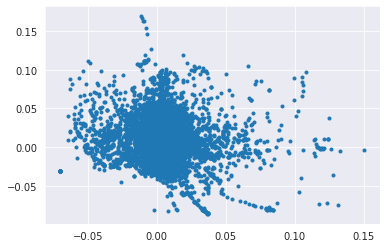

In [96]:
# the actual (old) stored values
pts_gt = np.load(HEATMAP_EXPERT_POINTS_PATH)
plt.plot(pts_gt[:,0], pts_gt[:,1], ".")
pts_gt.shape


In [84]:
!pwd

/webapps/piglegsurgery/devel


Error in Allgöwer_2.mp4: [Errno 2] No such file or directory: '/webapps/piglegsurgery/piglegsurgeryweb/media/SA_20221012-195221_2oyurueypemx/SA_20221012-195221/tracks_points.json'
Error in Allgöwer.mp4: [Errno 2] No such file or directory: '/webapps/piglegsurgery/piglegsurgeryweb/media/SA_20221012-195221_2oyurueypemx/SA_20221012-195221/tracks_points.json'
Error in Donati_Naht.webm: [Errno 2] No such file or directory: '/webapps/piglegsurgery/piglegsurgeryweb/media/SA_20230223-092526_kee3ccvp61y3/SA_20230223-092526/tracks_points.json'
Error in Allgöwer.webm: [Errno 2] No such file or directory: '/webapps/piglegsurgery/piglegsurgeryweb/media/SA_20221012-195221_2oyurueypemx/SA_20221012-195221/tracks_points.json'
Error in Allgöwer.MOV: [Errno 2] No such file or directory: '/webapps/piglegsurgery/piglegsurgeryweb/media/SA_20221012-195221_2oyurueypemx/SA_20221012-195221/tracks_points.json'
Error in Donati.MOV: [Errno 2] No such file or directory: '/webapps/piglegsurgery/piglegsurgeryweb/medi

<AxesSubplot:>

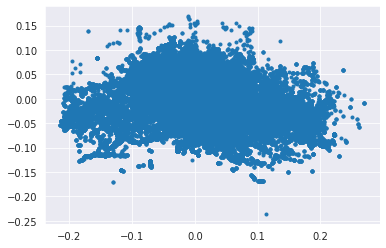

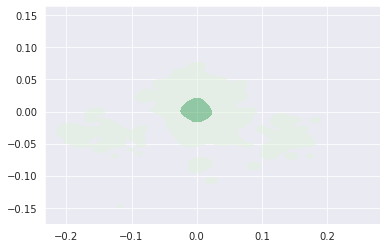

In [99]:

# dfall_expert = dfall[dfall["done_by_expert"]==True]["filename"].values
dfall_expert = dfall[dfall["done_by_expert"]==False]["filename"].values

points_expert = []
for fn in dfall_expert:
    try:
        patch = Path(fn).stem
        outputdir, mediafile_path = get_outputdir(patch)
        with open(outputdir / "tracks_points.json", "r") as f:
            tracks_points = json.load(f)
        with open(outputdir / "meta.json", "r") as f:
            meta = json.load(f)
        if "qr_data" not in meta:
            print(f"Skipping {patch}")
            continue
        pix_size_m = meta["qr_data"]["pix_size"]

        points_px = np.asarray(tracks_points["data_pixels"][0])
        points_normed = (points_px - np.median(points_px, axis=0)) * pix_size_m
        points_expert.append(points_normed)
    except Exception as e:
        print(f"Error in {fn}: {e}")
points_expert = np.concatenate(points_expert)
print(points_expert.shape)


plt.plot(points_expert[:,0], points_expert[:,1], ".")
plt.figure()


sns.kdeplot(x=points_expert[::10,0], y=points_expert[::10,1], cmap="Greens", fill=True, bw_adjust=1., levels=3,alpha=0.5)



2025-02-18 10:58:04.221 | DEBUG    | __main__:compare_heatmaps_plot:91 - points_px.shape=(592, 2)
2025-02-18 10:58:04.222 | DEBUG    | __main__:compare_heatmaps_plot:92 - pix_size_m=0.00043681433322102575


l2_distance=719.3792448894093


(719.3792448894093, 0.8026759489601863)

<Figure size 720x720 with 0 Axes>

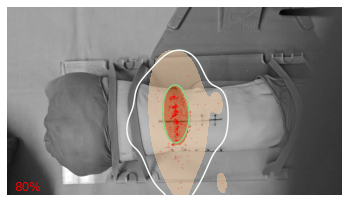

In [202]:

fn = np.random.choice(dfall[dfall["done_by_expert"]==True].filename.values)
patch = Path(fn).stem
patch
outputdir, mediafile_path = get_outputdir(patch)
plt.figure(figsize=(10,10))
compare_heatmaps_plot(outputdir, points_px=None, pix_size_m=None, filename=None, image=None, tool_id=0, cmap="Greens", levels=3)

In [48]:
with open(outputdir / "meta.json", "r") as f:
    meta = json.load(f)
meta

{'filename_full': '/webapps/piglegsurgery/piglegsurgeryweb/media/upload/20240820-093944_Ekn_Ana_12_663fae963c61a619fce961ce7f857a7539fc2b52/Ekn_Ana_12.mp4',
 'fps': 30,
 'frame_count': 1447}